## Hull White

Changed;
mu,
A, 
theta
r[] 

length -2145.7919627215015


/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_59157/3134347097.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  a = ((4*kappa*mu - v**2)*Y_s[i-1]**(-1) - (4*kappa)*Y_s[i-1])/8
/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_59157/3134347097.py:75: RuntimeWarning: divide by zero encountered in double_scalars
  ap = (-(4*kappa*mu - v**2)*Y_s[i-1]**(-2) - (4*kappa))/8
/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_59157/3134347097.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  app = (4*kappa*mu - v**2)*Y_s[i-1]**(-3)/4
/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_59157/3134347097.py:78: RuntimeWarning: invalid value encountered in double_scalars
  Y_s[i] = Y_s[i-1] + a*dt + b*dZ + (1/2)*(a*ap - (1/2)*app*b**2)*dt**2 + (1/2)*(ap*b)*dZ*dt


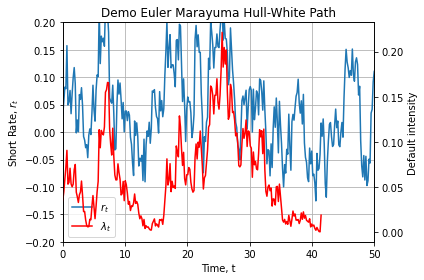

Correlation of output rho = 0.8: nan 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
from scipy.stats import norm
import scipy.optimize as optimize
import time
from joblib import Parallel, delayed
import scipy.integrate as integrate
from scipy import interpolate

plt.rcParams['text.usetex'] = False


# Set parameters, for clarity those related to the JCIR model will be preceded by a J and those related to the Hull white by an H
t0 = 0
T = 50

# Intensity params
lambda0 = 0.035
mu = 0.045
kappa = 0.3
v = 0.15

j_alpha = 0.001 # We should expect to see about 4 jumps,
gamma = 0.0005 # With expected size mu/5

# Short rate params
ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
interpolator =  interpolate.splrep(ti, Pi, s=0.0001)
P0T = lambda T: interpolate.splev(T, interpolator, der=0) #?

r0 = 0.03
alpha = 1
f0T = lambda t, dt=1e-4: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
theta = lambda t, dt=1e-4: (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + sigma*sigma/(2.0*alpha)*(1.0-np.exp(-2.0*alpha*t)) # Or choose theta ourselves??
sigma = 0.1 # vol

rand = Generator(PCG64())

## Generate Jumps for the JCIR
jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run rho 0.8 diffusion model for let's say 1280 time steps over our 10 time units, i.e. dt = 1/128
N = 6*T #T*128
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0, lambda0,len(t_s))
r = np.linspace(r0, r0,len(t_s))

# We could (should?) use Cholesky decomposition to covary the noise as well, but since multivariate_normal let's us generate correlated noise why not let it take care of it for us
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0.8
gen_noise = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s)))
Z_gen = gen_noise[:,0]
W_gen = gen_noise[:,1]

for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]
    dZ = np.sqrt(dt)*Z_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (theta(i*dt)-alpha*r[i-1])*dt + sigma*dW

    # Generate JCIR
    a = ((4*kappa*mu - v**2)*Y_s[i-1]**(-1) - (4*kappa)*Y_s[i-1])/8
    ap = (-(4*kappa*mu - v**2)*Y_s[i-1]**(-2) - (4*kappa))/8
    app = (4*kappa*mu - v**2)*Y_s[i-1]**(-3)/4
    b = (1/2)*v
    Y_s[i] = Y_s[i-1] + a*dt + b*dZ + (1/2)*(a*ap - (1/2)*app*b**2)*dt**2 + (1/2)*(ap*b)*dZ*dt
    lambdas[i] = Y_s[i]**2

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            Y_s[i] = np.sqrt(lambdas[i])
            jumps.pop(0)

    # Emergency negative catch
    if Y_s[i] < 0:
        Y_s[i] = 0
    
print("length", P0T(1280))
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_s,r,label = r"$r_t$")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s, lambdas, label = r"$\lambda_t$", color = "red")
ax2.set_ylabel("Default intensity")
ax1.set_title("Demo Euler Marayuma Hull-White Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Short Rate, $r_t$")
ax1.set_xlim((t0,T))
ax1.set_ylim(-0.2,0.2)
ax1.grid(True)
ax1.legend(handles= p1+p2, loc = "lower left")
plt.show()
print(r"Correlation of output rho = %s" %(rho1) + ": %s " %(np.corrcoef((lambdas,r))[0][1]))


length -2145.7919627215015


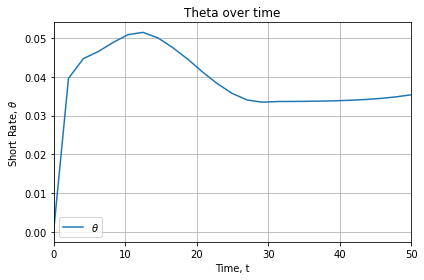

In [7]:
# See what theta looks like
t0 = 0
T = 50

# Short rate params
ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
interpolator =  interpolate.splrep(ti, Pi, s=0.0001)
P0T = lambda T: interpolate.splev(T, interpolator, der=0) #?

r0 = 0.03
alpha = 1
f0T = lambda t, dt=1e-4: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
theta = lambda t, dt=1e-4: (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + sigma*sigma/(2.0*alpha)*(1.0-np.exp(-2.0*alpha*t)) # Or choose theta ourselves??
# theta = r0*alpha # mean reversion, Varsicek
sigma = 0.1 # vol

rand = Generator(PCG64())

## Run rho 0.8 diffusion model for let's say 1280 time steps over our 10 time units, i.e. dt = 1/128
N = 25
t_s = np.linspace(t0,T,N)
r = np.linspace(r0, r0,len(t_s))

# We could (should?) use Cholesky decomposition to covary the noise as well, but since multivariate_normal let's us generate correlated noise why not let it take care of it for us
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0.8
gen_noise = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s)))
W_gen = gen_noise[:,1]
thetas = np.zeros(len(t_s))


for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (theta(i*dt)-alpha*r[i-1])*dt + sigma*dW
    thetas[i] = theta(dt*i)
    
print("length", P0T(1280))
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_s,thetas,label = r"$\theta$")
ax1.set_title("Theta over time")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Short Rate, $\theta$")
ax1.set_xlim((t0,T))
#ax1.set_ylim(-0.01,1)
ax1.grid(True)
ax1.legend(handles= p1, loc = "lower left")
plt.show()

### Pricing Swaptions Semi-Analytically
What is written below is based almost entirely on the Lecture slides created by [Grezlak](https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/tree/main), specifically lectures 4, 5 and 7. (We have this in the projektplan)

We're operating under the Hull-White model 
$$dr_t = (\theta - \alpha r_t)dt + \sigma_t dW_t$$
assuming constant variance $\sigma$ (to begin with) we can price the European Swaption with nominal N using European puts on ZCB:s (Magnus Slides)
$$N\cdot\mathrm{P}(t_0, T_m)\sum_{k = m+1}^{n}c_kV_{T_m,T_k}^{\mathrm{ZCB}}(t_0,\hat{K},-1)$$
with
$$\hat{K} = e^{A + B\cdot r^*}$$
and $c_k$, $r^*$ chosen such that
$$1 - \sum_{k = m+1}^{n}c_k \mathrm{exp}\left(A(T_m,T_k) + B(T_m,T_k)r^*\right) = 0 \\
c_k = K \tau_k ~ \forall (k \in \{m+1,...,n-1\}) \\
c_n = K(1 + \tau_n)$$
and the functions + price of ZCB
$$A(t,T) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (T-t)} - 4e^{-\alpha (T-t)} - 2\alpha (T-t) \right) + \alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz$$
$$B(t,T) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(T-t)} \right) $$
$$P(t,T) = \mathrm{exp}(A(t,T) + B(t,T)r(t)) $$
we can solve the integral analytically for fixed $\alpha$ and $\theta$
$$\alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz = -\frac{\theta}{\alpha}\int_{t}^{T}1 - e^{-\alpha T} e^{\alpha z}dz \\
= -\frac{\theta}{\alpha}[z - \frac{1}{\alpha}e^{-\alpha T}e^{\alpha z}]_{t}^{T} = -\frac{\theta}{\alpha}\left((T-t) - \frac{1}{\alpha}(1 - e^{-\alpha(T - t)})\right)$$
So we can rephrase $A(t,T) = [\tau = T - t] = A(\tau)$ and $B(t,T) = B(\tau)$ as
$$A(\tau) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (\tau)} - 4e^{-\alpha (\tau)} - 2\alpha (\tau) \right) - \frac{\theta}{\alpha}\left((\tau) - \frac{1}{\alpha}(1 - e^{-\alpha(\tau)})\right)$$
$$B(\tau) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(\tau)} \right)$$


### Pricing Swaptions Semi-Analytically HW
$$A(\tau) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (\tau)} - 4e^{-\alpha (\tau)} - 2\alpha (\tau) \right) + \int_{t}^{T}\theta B(z,T)dz $$
$$B(\tau) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(\tau)} \right)$$

#### Pricing ZCB put
We can price the ZCB put option as 
$$V_c^{\mathrm{ZCB}}(t_0,T) = P(t_0,T) e^{A(\tau)}\left[\mathrm{exp}(\frac{1}{2}B(\tau)^2v_r^2(t_0,T) + B(\tau)\mu_r(t_0,T))\mathit{F}_{\mathcal{N}(0,1)}(\mathit{d_1}) - \hat{K}_2\mathit{F}_{\mathcal{N}(0,1)}(d_2) \right]\\
d_1 = a - B(\tau)v_r(t_0,T),~~d_2 = d_1 + B(\tau)v_r(t_0,T), ~~ \hat{K}_2 = Ke^{-A(\tau)} \\
a = \frac{\mathrm{log}\hat{K}_2 - B(\tau)\mu(t_0,T)}{B(\tau)v_r(t_0,T)} \\
\mu(t_0,T) = r_0e^{-\alpha(T-t_0)} + \alpha\int_{t_0}^T\hat{\theta}(z,T)e^{-\alpha(T-z)}dz \\
= \left[\hat{\theta} = \theta/\alpha + \frac{\sigma^2}{\alpha^2}(e^{-\alpha(T-t)} -1)\right] = r_0e^{-\alpha(T-t_0)} + \int_{t_0}^T(\theta(z,T) + \frac{\sigma^2}{\alpha}(e^{-\alpha(T-)}-1))e^{-\alpha(T-z)}dz\\
= [\theta~\mathrm{ const}] = r_0e^{-\alpha(T-t_0)} + \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\int_{t_0}^T e^{-2\alpha(T-z)} - e^{-\alpha(T-z)}dz \\
= r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}[e^{-2\alpha(T-z)}]^T_{t_0} - \frac{1}{\alpha}[e^{-\alpha(T-z)}]_{t_0}^T \right) \\
= r_0e^{-\alpha(T-t_0)} - \frac{1}{\alpha}(\frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}(1 - e^{-2\alpha(T-t_0)}) - \frac{1}{\alpha}(1 - e^{-\alpha(T-t_0)}) \right)) \\
 v_r^2(t_0,T) = \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha(T-t_0)})$$

with all this legwork done we have a cumbersome but almost explicit (explicit once you've found $r^*$) expression for the value of an option constant parameter Hull-White.

#### Pricing ZCB put using HW
$$\mu(t_0,T) = r_0e^{-\alpha(T-t_0)} + \alpha\int_{t_0}^T\hat{\theta}(z,T)e^{-\alpha(T-z)}dz \\
= \left[\hat{\theta} = \theta/\alpha + \frac{\sigma^2}{\alpha^2}B(z,t)\right] = r_0e^{-\alpha(T-t_0)} + \int_{t_0}^T\theta(z,T)e^{-\alpha(T-z)}dz +  \frac{\sigma^2}{\alpha} \int_{t_0}^TB(z,T)e^{-\alpha(T-z)}dz\\$$

with all this legwork done we have a cumbersome but almost explicit (explicit once you've found $r^*$) expression for the value of an option constant parameter Hull-White.

In [ ]:
# General functions, time dependent theta
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) + integrate.trapz([theta(z)*B(z,T) for z in np.linspace(t, T, 100)], x=np.linspace(t, T, 100)) #t=tm, T=tk
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
Khat = lambda t,T, rstar: np.e**(A(t,T) + B(t,T)*rstar)
P = lambda t,T,rt: np.e**(A(t,T)+B(t,T)*rt)

# Put on ZCB functions
Fn = lambda arg: norm.cdf(arg)
mu_v = lambda t, T, r0: r0*np.e**(-alpha*(T - t)) + integrate.trapz([theta(z)*np.exp(-alpha*(T-z)) for z in np.linspace(t, T, 100)], # T = tm. int from t to Tm
        x=np.linspace(t, T, 100))+ (sigma**2)*(1/alpha)*integrate.trapz([theta(z)*np.exp(-alpha*(T-z)) for z in np.linspace(t, T, 100)], # T = tm. int from t to Tm
        x=np.linspace(t, T, 100))
v_r2 = lambda t,T: (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
B_bar = lambda tau: B(0,tau) # This only works since theta constant otherwise this would need t dependence
A_bar = lambda tau: A(0,tau) # --||--
Khat2 = lambda tau, K: K*np.e**(-A_bar(tau))
a = lambda t,T,tau,K, r0: (np.log(Khat2(tau,K)) - B_bar(tau)*mu_v(t,T,r0))/(B_bar(tau)*(v_r2(t,T))**(1/2))

d1 = lambda t,T,tau,K,r0: a(t,T,tau,K,r0) - B_bar(tau)*(v_r2(t,T)**(1/2))
d2 = lambda t,T,tau,K,r0: d1(t,T,tau,K,r0) + B_bar(tau)*(v_r2(t,T)**(1/2))


# Value of a put option on a ZCB, option expiry T before or at payout date of ZCB T + tau, for call pass type = 0 for put type = 1
def VZCB(t,T,tau,K,rt, type): #CHANGE!!!!!
    # t = t
    # T = Tm
    term1 =  np.exp((0.5*B_bar(tau)**2*v_r2(t,T) + B_bar(tau)*mu_v(t,T,rt)))*Fn(d1(t,T,tau,K,rt)) - Khat2(tau,K)*Fn(d2(t,T,tau,K,rt))
    call_value = P(t,T,rt)*np.exp(A_bar(tau))*term1 
    return call_value + type*(-P(t,T+tau,rt) + K*P(t,T,rt))
# c_k from schedule
cashflows = lambda K, Ts: (K*np.diff(Ts) + np.concatenate((np.zeros((1,len(Ts)-2)), np.asmatrix(1)),1)).A1

# Solve for rstar
minimize = lambda cashflows, dates, Tm, rstar: 1 - sum([c*np.e**(A(Tm,date) + B(Tm,date)*rstar) for c, date in zip(cashflows,dates)])
def rstar(cashflows, dates, Tm):
    optim = lambda rstarl: minimize(cashflows, dates, Tm, rstarl)
    return optimize.newton(optim, 0, rtol=1e-5, tol = 1e-8)

# Solve for swap price
swap_price = lambda t,rt,T_s, K: P(t,T_s[0],rt) - P(t,T_s[-1],rt) - K*sum([tau_k*P(t,T_k,rt) for tau_k, T_k in zip(np.diff(T_s),T_s[1:])])

# Solve for Payer Swaption (Get floating pay fixed)with nominal 1
def swaption_price(t, rt, T_s, K):
    T_m = T_s[0] # The entrance date
    dates = T_s[1:] # The payment dates
    cashs = cashflows(K, T_s) # The Cashflows

    if (T_m-t<=0.00):
        value = np.max((0,swap_price(T_m,rt,T_s,K)))
    else:
        rst = rstar(cashs, dates, T_m) # Rstar
        value = (sum([c*VZCB(t, T_m, Tk-T_m, Khat(T_m,Tk,rst), rt, 1) for c, Tk in list(zip(cashs,dates))]))
    return value


In [ ]:
# original
# General functions
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) - (theta/alpha)*((T-t) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
Khat = lambda t,T, rstar: np.e**(A(t,T) + B(t,T)*rstar)
P = lambda t,T,rt: np.e**(A(t,T)+B(t,T)*rt)

# Put on ZCB functions
Fn = lambda arg: norm.cdf(arg)
mu_v = lambda t, T, r0: r0*np.e**(-alpha*(T - t)) + (theta/alpha)*(1 - np.e**(-alpha*(T - t))) + (sigma**2)*(1/alpha)*((1/(2*alpha))*(1 - np.e**(-2*alpha*(T-t))) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
v_r2 = lambda t,T: (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
B_bar = lambda tau: B(0,tau) # This only works since theta constant otherwise this would need t dependence
A_bar = lambda tau: A(0,tau) # --||--
Khat2 = lambda tau, K: K*np.e**(-A_bar(tau))
a = lambda t,T,tau,K, r0: (np.log(Khat2(tau,K)) - B_bar(tau)*mu_v(t,T,r0))/(B_bar(tau)*(v_r2(t,T))**(1/2))

d1 = lambda t,T,tau,K,r0: a(t,T,tau,K,r0) - B_bar(tau)*(v_r2(t,T)**(1/2))
d2 = lambda t,T,tau,K,r0: d1(t,T,tau,K,r0) + B_bar(tau)*(v_r2(t,T)**(1/2))

# Value of a put option on a ZCB, option expiry T before or at payout date of ZCB T + tau, for call pass type = 0 for put type = 1
def VZCB(t,T,tau,K,rt, type):
    term1 =  np.exp((0.5*B_bar(tau)**2*v_r2(t,T) + B_bar(tau)*mu_v(t,T,rt)))*Fn(d1(t,T,tau,K,rt)) - Khat2(tau,K)*Fn(d2(t,T,tau,K,rt))
    call_value = P(t,T,rt)*np.exp(A_bar(tau))*term1 
    return call_value + type*(-P(t,T+tau,rt) + K*P(t,T,rt))
# c_k from schedule
cashflows = lambda K, Ts: (K*np.diff(Ts) + np.concatenate((np.zeros((1,len(Ts)-2)), np.asmatrix(1)),1)).A1

# Solve for rstar
minimize = lambda cashflows, dates, Tm, rstar: 1 - sum([c*np.e**(A(Tm,date) + B(Tm,date)*rstar) for c, date in zip(cashflows,dates)])
def rstar(cashflows, dates, Tm):
    optim = lambda rstarl: minimize(cashflows, dates, Tm, rstarl)
    return optimize.newton(optim, 0, rtol=1e-5, tol = 1e-8)

# Solve for swap price
swap_price = lambda t,rt,T_s, K: P(t,T_s[0],rt) - P(t,T_s[-1],rt) - K*sum([tau_k*P(t,T_k,rt) for tau_k, T_k in zip(np.diff(T_s),T_s[1:])])

# Solve for Payer Swaption (Get floating pay fixed)with nominal 1
def swaption_price(t, rt, T_s, K):
    T_m = T_s[0] # The entrance date
    dates = T_s[1:] # The payment dates
    cashs = cashflows(K, T_s) # The Cashflows

    if (T_m-t<=0.00):
        value = np.max((0,swap_price(T_m,rt,T_s,K)))
    else:
        rst = rstar(cashs, dates, T_m) # Rstar
        value = (sum([c*VZCB(t, T_m, Tk-T_m, Khat(T_m,Tk,rst), rt, 1) for c, Tk in list(zip(cashs,dates))]))
    return value


### Pricing swaptions

/var/folders/w2/tryhyd3s6p92f13xh82mvk6r0000gn/T/ipykernel_38059/2380930287.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  swapt_prices[i] = (1/P(0,t_s[i],r[0]))**(1/t_s[i])-1


Swaption value at time 0.0 = 0: 0.0


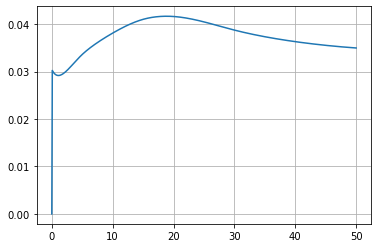

In [ ]:
# Looking good
T_s = np.arange(10,21,1)
Fixed = 0.02
swapt_prices = np.zeros(len(t_s))

for i in np.arange(0,len(t_s)):
    swapt_prices[i] = (1/P(0,t_s[i],r[0]))**(1/t_s[i])-1
    
print("Swaption value at time %s = 0: %s" %(t_s[0], swapt_prices[0]))

plt.figure(1)
plt.grid()
plt.plot(t_s,swapt_prices,label = "Swaption value")

Swaption value at time 0.0 = 0: [0.13732913]
0.03


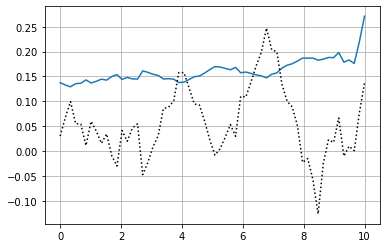

In [ ]:
# HULL WHITE
T_s = np.arange(10,21,1)
Fixed = 0.02
swap_prices = np.zeros((len(t_s),1))
swapt_prices = np.zeros((len(t_s),1))

for i in np.arange(0,len(t_s)):
    swapt_prices[i] = swaption_price(t_s[i],r[i], T_s, Fixed)
    
print("Swaption value at time %s = 0: %s" %(t_s[0], swapt_prices[0]))
print(r[0])

plt.figure(1)
plt.grid()
plt.plot(t_s,swapt_prices,label = "Swaption value")
plt.plot(t_s, r, label = r"r_t", color = "black",linestyle = ':')


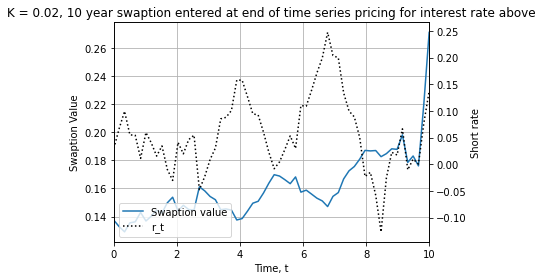

In [ ]:
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_s,swapt_prices,label = "Swaption value")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %Fixed)
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s, r, label = r"r_t", color = "black",linestyle = ':')
ax2.set_ylabel("Short rate")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles=p1+p2, loc = "lower left")
plt.show()

Swaption value at time 0.0 = 0: [0.04368565]
0.03


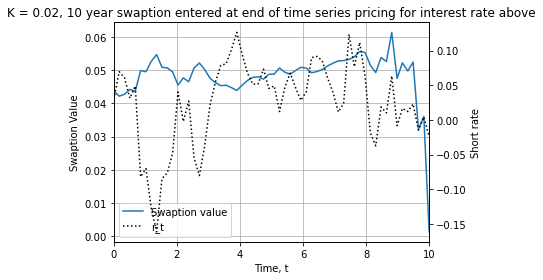

In [ ]:
# Varsicek
T_s = np.arange(10,21,1)
Fixed = 0.02
swap_prices = np.zeros((len(t_s),1))
swapt_prices = np.zeros((len(t_s),1))

for i in np.arange(0,len(t_s)):
    swapt_prices[i] = swaption_price(t_s[i],r[i], T_s, Fixed)
    
print("Swaption value at time %s = 0: %s" %(t_s[0], swapt_prices[0]))
print(r[0])

'''
plt.figure(1)
plt.grid()
plt.plot(t_s,swapt_prices,label = "Swaption value")
plt.plot(t_s, r, label = r"r_t", color = "black",linestyle = ':')
''' 


fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_s,swapt_prices,label = "Swaption value")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %Fixed)
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s, r, label = r"r_t", color = "black",linestyle = ':')
ax2.set_ylabel("Short rate")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles=p1+p2, loc = "lower left")
plt.show()


